In [2]:
##installs pytorch on a cuda-capable windows machine using pip

%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

%pip install torchsummary

%pip install numpy

%pip install matplotlib

%pip install opencv-python

%pip install scikit-learn

%pip install pandas

%pip install tqdm

%pip install pickle5

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pickle5
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for pickle5 (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickle.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\__init__.py -> build\lib.win-amd64-cpython-312\pickle5
      creating build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-312\pickle5\test
      running build_ext
      building 'pickle5._pickle' exte

In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = torch.cuda.is_available()
print(cuda)

Current Working Directory: progettoVIPM
True


In [4]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset

In [5]:
from utils.extractNeuralFeatures import extract_features

In [6]:
chosen_net = networks.ALEXNET
print("Original classification layers:{}".format(chosen_net.value[1]))

Original classification layers:AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, 

In [7]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu

linear_layers_to_remove = 2
X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers = extract_features(train_set=datasets.TRAINING_LABELED,
                                                                                            test_set=datasets.TEST,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=linear_layers_to_remove, 
                                                                                            cuda=cuda)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("---------------------------------------------------------------------------------")
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Found an existing set of features in: ./Storage/neural_features/Train_AlexNet_minus2_train_set.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 5020
Feature vector shape of Train: (5020, 4096)
Label vector shape of Train: (5020,)
---------------------------------------------------------------------------------
Found an existing set of features in: ./Storage/neural_features/Test_AlexNet_minus2_val_set.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 11994
Feature vector shape of Test: (11994, 4096)
Label vector shape of Test: (11994,)
---------------------------------------------------------------------------------
Original classification layers:Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def model_building(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.savefig("./Transfer_Learning/model_metrics/ConfM_{}.pdf".format(model_name))
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    with open('./Storage/models/{}.pkl'.format(model_name),'wb') as f:
        pickle.dump(model,f)
    return acc

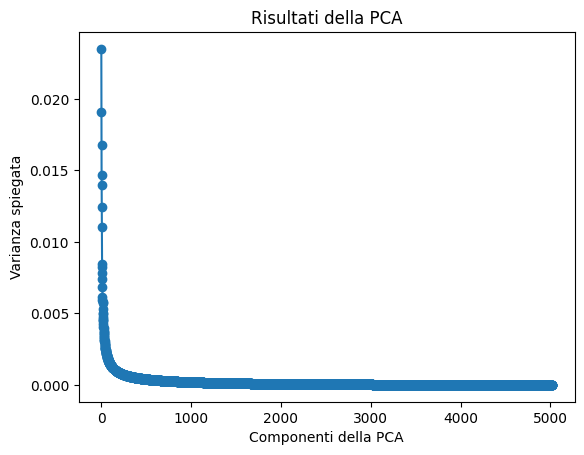

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

is_pca_used = False

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train_ale_n)
pca = PCA().fit(scaled_data)

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()


In [18]:
components = 500
pca = PCA(n_components=components).fit(scaled_data)
X_train_pca = pca.transform(scaled_data)
print("Final input shape train: {}".format(X_train_pca.shape))

scaled_data = scaler.fit_transform(X_test_ale_n)
x_test_pca = pca.transform(scaled_data)
print("Final input shape test: {}".format(x_test_pca.shape))

Final input shape train: (5020, 500)
Final input shape test: (11994, 500)


In [ ]:

from enum import Enum
class ml_models(Enum):
    LINEAR_SVC = [LinearSVC(), "Linear Support Vector"]
    RBF_SVC = [SVC(kernel="rbf"), "Rbf Support Vector"]
    # RANDOM_FOREST = [RandomForestClassifier(), "Random Forest"]
    # BOOSTED_FOREST = [GradientBoostingClassifier(), "Gradient Boosting Classifier"]
    KNN_1 = [KNeighborsClassifier(n_neighbors=1), "KNN with 1 neighbors"]
    KNN_10 = [KNeighborsClassifier(n_neighbors=10), "KNN with 10 neighbors"]
    KNN_20 = [KNeighborsClassifier(n_neighbors=20), "KNN with 20 neighbors"]
    KNN_50 = [KNeighborsClassifier(n_neighbors=50), "KNN with 50 neighbors"]
    NAIVE_BAYES = [GaussianNB(), "Naive Bayes"]

is_pca_used = True

x_train = X_train_ale_n
x_test = X_test_ale_n
if is_pca_used:
    x_train = X_train_pca
    x_test =x_test_pca
model_accuracies = []
for model in tqdm(ml_models):    
    model_name = "{}_from_{}_minus{}".format(model.value[1], chosen_net.value[2], linear_layers_to_remove)
    if is_pca_used:
        model_name += "_pca"
    score = model_building(model.value[0], model_name, x_train, x_test, y_train, y_test)
    print("{} obtained following accuracy: {}".format(model.value[1],score))
    model_accuracies.append([model_name, score])
model_accuracies = np.array(model_accuracies)
accuracies_filename = "./Transfer_Learning/model_metrics/Accuracies_{}_minus{}".format(chosen_net.value[2], linear_layers_to_remove)
if is_pca_used:
    accuracies_filename += "_pca"
np.save("{}.npy".format(accuracies_filename), model_accuracies)

  0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
from utils.fine_tune_pytorch import fine_tune_network_layers, eval_model_on_test_set
from copy import deepcopy

In [9]:
for param in fine_tune_layers.parameters():
    print(param.requires_grad)
    
loss_function = torch.nn.CrossEntropyLoss()

model = deepcopy(fine_tune_layers)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 50
batch_size = 128
trained_model, losses, accuracies = fine_tune_network_layers(cuda, model=model, x_train=X_train_ale_t, y_train=y_train, n_epochs=n_epochs,
                                                 batch_size=batch_size, loss_function=loss_function, optimizer=optimizer)

EPOCH 50:
LOSS: train 0.4120283954449602; valid 4.049596691131592


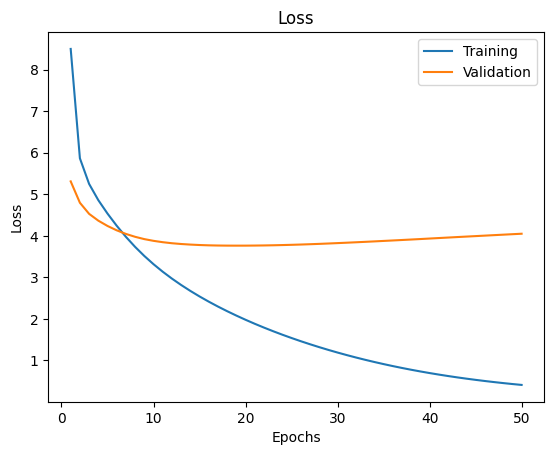

In [10]:
def plot_loss(history):
  x_plot = list(range(1,len(history)+1))
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history[:,0])
  plt.plot(x_plot, history[:,1])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history):
  x_plot = list(range(1,len(history)+1))
  plt.figure()
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history[:,0])
  plt.plot(x_plot, history[:,1])
  plt.legend(['Training', 'Validation'])


# print(losses)
plot_loss(losses)
plot_accuracy(accuracies)

In [11]:
cm = eval_model_on_test_set(trained_model, model_name="Alexnet_minus2_50_epoch", target_dir="Transfer_Learning", x_test=X_test_ale_t, y_test=y_test, cuda=cuda)

100%|██████████| 11994/11994 [00:27<00:00, 429.91it/s]

Accuracy: 0.14732366183091547


In [18]:
%pip install tensorboardX

Note: you may need to restart the kernel to use updated packages.


In [80]:
def train_one_epoch(epoch_index, tb_writer, training_loader, model, loss_function, optimizer):
    running_loss = 0.
    avg_batch_loss = 0.
    n_batch = 0
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_function(outputs, labels)
        avg_batch_loss += loss.item()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        # running_loss += loss.item()
        # if i % 10 == 9:
        #     last_loss = running_loss / 10 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     tb_x = epoch_index * len(training_loader) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.
        n_batch += 1

    return avg_batch_loss/n_batch

In [21]:
from datetime import datetime
from tensorboardX import SummaryWriter
from IPython.display import clear_output
def train_model(training_loader, validation_loader, n_epochs, model, loss_function, optimizer):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/trainer_{}'.format(timestamp))

    epoch_number = 0


    best_vloss = 1_000_000.

    losses = np.empty((n_epochs,2))


    for epoch in range(n_epochs):
        clear_output(wait=True)
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer, training_loader, model, loss_function, optimizer)


        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_function(voutputs, vlabels)
                running_vloss += vloss.item()

        avg_vloss = running_vloss / (i + 1)
        losses[epoch_number] = [avg_loss, avg_vloss]
        print('LOSS: train {}; valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        # if avg_vloss < best_vloss:
        #     best_vloss = avg_vloss
        #     model_path = './Transfer_Learning/models/neural/model_{}_{}'.format(timestamp, epoch_number)
        #     torch.save(model.state_dict(), model_path)

        epoch_number += 1
    return model, losses

In [84]:
trained_model.eval()

predictions = np.zeros(len(test_loader))
# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    i = 0
    for test_data in tqdm(test_loader):
        test_features, test_labels = test_data
        predictions[i] = np.argmax(np.array(trained_model(test_features).cpu()))
        i+=1
y_test = np.array(y_test.cpu())
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {}".format(accuracy))
cm = confusion_matrix(y_test, predictions)
cm = np.array(cm)
model_name="Alexnet"
np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
        

100%|██████████| 11994/11994 [00:07<00:00, 1618.24it/s]

Accuracy: 0.1424045356011339
